In [8]:
from google.colab import drive

In [9]:
drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


In [10]:
##Assessing the Jena weather dataset's data
import os
data_dir = '/content'
fname = os.path.join(data_dir, '/content/drive/MyDrive/Copy of jena_climate_2009_2016.csv')

In [11]:
from matplotlib import lines
with open(fname) as f: data = f.read()

In [12]:
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [13]:
import numpy as np

In [14]:
# load data directly into NumPy arrays and Skip the header row
data = np.array([line.split(",")[1:] for line in lines[1:]], dtype=np.float32)

In [15]:
 #Retrieve the temperature readings.
temperature = data[:, 1]  # If temperature is different from what you assume it is in the second column, adjust the index.

In [16]:
# Remove out the Date, Time, and Temperature columns from the extracted raw data.
raw_data = data[:, 2:]  # If needed adjust the columns.

In [17]:
# The raw_data and temperature arrays are now correctly populated.

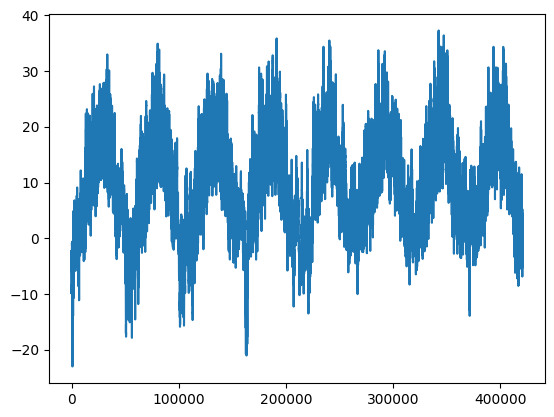

In [18]:
import matplotlib.pyplot as plt
###Plotting the temperature timeseries
plt.plot(range(len(temperature)), temperature)

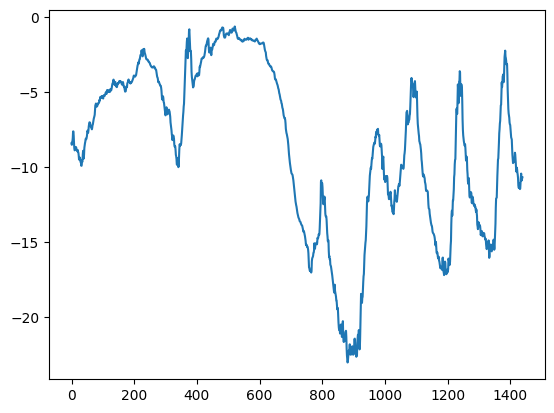

In [19]:
##Plotting the temperature timeseries' initial ten days
plt.plot(range(1440), temperature[:1440])

In [20]:
""" figuring out how many samples each data split will demand """
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105113


Setting up the data

In [21]:
#Normalizing the data
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [22]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

In [23]:
for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


Generating datasets in real time for testing, validation, and training

In [24]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

In [25]:
# Typical parameters for creating datasets
common_params = {
    "sampling_rate": sampling_rate,
    "sequence_length": sequence_length,
    "shuffle": True,
    "batch_size": batch_size,
}

In [26]:
# Create train, validation, and test datasets
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    start_index=0,
    end_index=num_train_samples,
    **common_params
)

In [27]:
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples,
    **common_params
)

In [28]:
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    start_index=num_train_samples + num_val_samples,
    **common_params
)


In [29]:
for samples, targets in train_dataset.take(1):
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)

samples shape: (256, 120, 12)
targets shape: (256,)


Model with baseline in non-machine learning

In [30]:
def calculate_mae(dataset, std, mean):
    total_absolute_error = 0
    total_samples = 0
    for samples, targets in dataset:
        predicted_values = samples[:, -1, 1] * std[1] + mean[1]
        total_absolute_error += np.sum(np.abs(predicted_values - targets))
        total_samples += samples.shape[0]
    mae = total_absolute_error / total_samples  # For calculating the MAE, use floating-point division.
    return mae
validation_mae = calculate_mae(val_dataset, std, mean)
test_mae = calculate_mae(test_dataset, std, mean)
print(f"Validation MAE: {validation_mae:.2f}")
print(f"Test MAE: {test_mae:.2f}")

Validation MAE: 4.73
Test MAE: 5.24


Basic machine-learning model

In [31]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [32]:
callbacks = [keras.callbacks.ModelCheckpoint("jena_dense.keras",save_best_only=True)]

In [33]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [34]:
history = model.fit(train_dataset, epochs=10,
                    validation_data = val_dataset, callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 10s 11ms/step - loss: 13.0676 - mae: 2.7972 - val_loss: 10.6584 - val_mae: 2.5634
Epoch 2/10
819/819 [==============================] - 10s 12ms/step - loss: 9.4910 - mae: 2.4219 - val_loss: 10.4300 - val_mae: 2.5397
Epoch 3/10
819/819 [==============================] - 9s 11ms/step - loss: 8.7396 - mae: 2.3273 - val_loss: 10.8658 - val_mae: 2.5882
Epoch 4/10
819/819 [==============================] - 10s 12ms/step - loss: 8.2901 - mae: 2.2702 - val_loss: 15.1205 - val_mae: 3.0802
Epoch 5/10
819/819 [==============================] - 10s 12ms/step - loss: 7.9770 - mae: 2.2295 - val_loss: 10.2935 - val_mae: 2.5238
Epoch 6/10
819/819 [==============================] - 9s 11ms/step - loss: 7.7350 - mae: 2.1948 - val_loss: 12.5796 - val_mae: 2.7696
Epoch 7/10
819/819 [==============================] - 9s 11ms/step - loss: 7.5475 - mae: 2.1709 - val_loss: 10.9161 - val_mae: 2.5901
Epoch 8/10
819/819 [==============================] - 9s 

OUTLINING THE RESULT

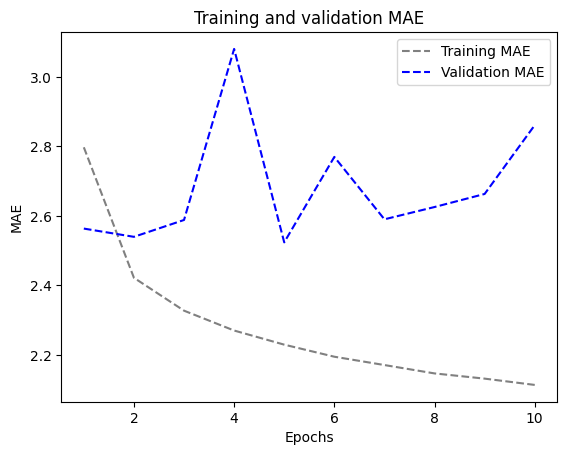

In [35]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

We will attempt a 1D convolutional model.

In [36]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [37]:
callbacks = [ keras.callbacks.ModelCheckpoint("jena_conv.keras", save_best_only=True) ]

In [38]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [39]:
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 13s 14ms/step - loss: 24.9317 - mae: 3.8934 - val_loss: 16.2591 - val_mae: 3.2122
Epoch 2/10
819/819 [==============================] - 13s 16ms/step - loss: 16.5086 - mae: 3.2306 - val_loss: 17.1093 - val_mae: 3.2275
Epoch 3/10
819/819 [==============================] - 13s 16ms/step - loss: 14.9516 - mae: 3.0733 - val_loss: 14.6978 - val_mae: 3.0297
Epoch 4/10
819/819 [==============================] - 13s 16ms/step - loss: 14.0935 - mae: 2.9828 - val_loss: 15.7342 - val_mae: 3.1054
Epoch 5/10
819/819 [==============================] - 11s 14ms/step - loss: 13.4873 - mae: 2.9129 - val_loss: 16.2539 - val_mae: 3.1575
Epoch 6/10
819/819 [==============================] - 13s 16ms/step - loss: 12.9959 - mae: 2.8574 - val_loss: 14.0526 - val_mae: 2.9641
Epoch 7/10
819/819 [==============================] - 14s 17ms/step - loss: 12.5737 - mae: 2.8075 - val_loss: 17.3569 - val_mae: 3.2589
Epoch 8/10
819/819 [============================

In [42]:
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 3s 7ms/step - loss: 15.7169 - mae: 3.1421
Test MAE: 3.14


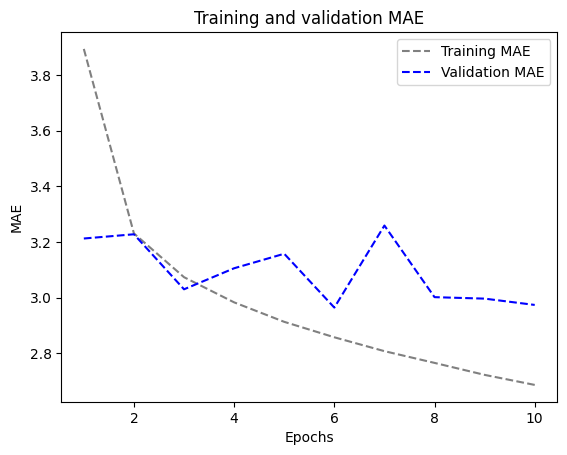

In [43]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

A fundamental model based on LSTM

In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [45]:
#develop the LSTM model and describe the input shape.
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [46]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)
]

In [48]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_lstm.keras")
test_loss, test_mae = model.evaluate(test_dataset)
print(f"Test MAE: {test_mae:.2f}")

Epoch 1/10
819/819 [==============================] - 49s 57ms/step - loss: 45.3563 - mae: 4.9181 - val_loss: 13.0853 - val_mae: 2.7234
Epoch 2/10
819/819 [==============================] - 46s 56ms/step - loss: 11.1471 - mae: 2.6077 - val_loss: 9.9365 - val_mae: 2.4360
Epoch 3/10
819/819 [==============================] - 45s 55ms/step - loss: 9.9090 - mae: 2.4680 - val_loss: 9.8708 - val_mae: 2.4296
Epoch 4/10
819/819 [==============================] - 46s 56ms/step - loss: 9.2971 - mae: 2.3869 - val_loss: 9.4962 - val_mae: 2.3810
Epoch 5/10
819/819 [==============================] - 46s 56ms/step - loss: 8.7092 - mae: 2.3101 - val_loss: 9.5333 - val_mae: 2.3794
Epoch 6/10
819/819 [==============================] - 46s 56ms/step - loss: 8.4212 - mae: 2.2738 - val_loss: 9.8006 - val_mae: 2.3998
Epoch 7/10
819/819 [==============================] - 45s 55ms/step - loss: 8.2452 - mae: 2.2481 - val_loss: 9.7377 - val_mae: 2.4053
Epoch 8/10
819/819 [==============================] - 46s 5

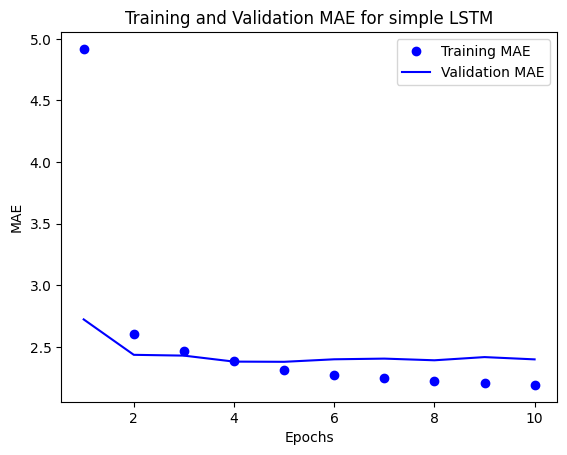

In [49]:
##Plotting results
import matplotlib.pyplot as plt
# Provided that you possess a "history" object that includes training records
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(mae) + 1)
plt.figure()
plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and Validation MAE for simple LSTM')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


Adjusting Units in Recurrent Layers: A Basic GRU-Based Model

In [51]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Describe the model.
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


# Determine callbacks for maintaining the best possible model.
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras", save_best_only=True)
]


# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

# Utilizing the test dataset, load and evaluate the most appropriate model.
model = keras.models.load_model("jena_gru.keras")
test_loss, test_mae = model.evaluate(test_dataset)
print(f"Test MAE: {test_mae:.2f}")


Epoch 1/10
819/819 [==============================] - 46s 54ms/step - loss: 36.3129 - mae: 4.3780 - val_loss: 12.3998 - val_mae: 2.6713
Epoch 2/10
819/819 [==============================] - 45s 55ms/step - loss: 10.7676 - mae: 2.5588 - val_loss: 9.8849 - val_mae: 2.4363
Epoch 3/10
819/819 [==============================] - 43s 53ms/step - loss: 9.7560 - mae: 2.4432 - val_loss: 9.9717 - val_mae: 2.4326
Epoch 4/10
819/819 [==============================] - 44s 53ms/step - loss: 9.3846 - mae: 2.3944 - val_loss: 9.9765 - val_mae: 2.4337
Epoch 5/10
819/819 [==============================] - 43s 53ms/step - loss: 9.1261 - mae: 2.3629 - val_loss: 10.7930 - val_mae: 2.5103
Epoch 6/10
819/819 [==============================] - 44s 54ms/step - loss: 8.9364 - mae: 2.3404 - val_loss: 11.6083 - val_mae: 2.6040
Epoch 7/10
819/819 [==============================] - 43s 53ms/step - loss: 8.7592 - mae: 2.3197 - val_loss: 11.0734 - val_mae: 2.5451
Epoch 8/10
819/819 [==============================] - 44

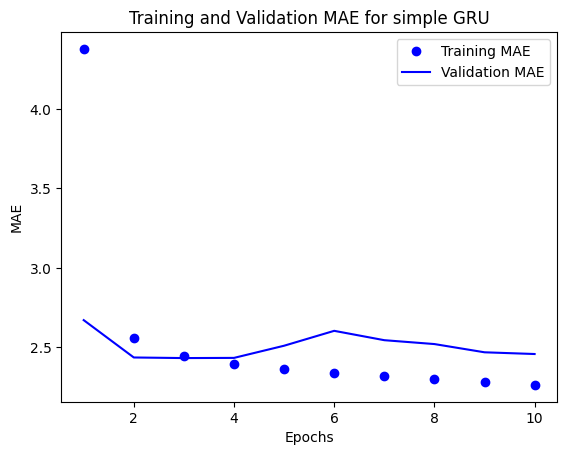

In [52]:
##Plotting results
import matplotlib.pyplot as plt
# assuming you have an object that has a "history" that contains training records
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(mae) + 1)
plt.figure()
plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and Validation MAE for simple GRU')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


LSTM swapping for GRU: training and assessing a dropout-regularized LSTM

In [54]:
# Provide the model a dropout layer definition.
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
# Determine callbacks to preserve the best possible model.
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras", save_best_only=True)
]
# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
# Train the model for 30 epochs
history = model.fit(train_dataset, epochs=30, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/30
819/819 [==============================] - 81s 96ms/step - loss: 29.9781 - mae: 4.0286 - val_loss: 10.3926 - val_mae: 2.4981
Epoch 2/30
819/819 [==============================] - 79s 96ms/step - loss: 15.0424 - mae: 3.0150 - val_loss: 9.6965 - val_mae: 2.4043
Epoch 3/30
819/819 [==============================] - 77s 94ms/step - loss: 13.9080 - mae: 2.8969 - val_loss: 9.4287 - val_mae: 2.3826
Epoch 4/30
819/819 [==============================] - 78s 96ms/step - loss: 13.2398 - mae: 2.8275 - val_loss: 9.5349 - val_mae: 2.4001
Epoch 5/30
819/819 [==============================] - 80s 98ms/step - loss: 12.8422 - mae: 2.7791 - val_loss: 9.8626 - val_mae: 2.4312
Epoch 6/30
819/819 [==============================] - 79s 97ms/step - loss: 12.3637 - mae: 2.7303 - val_loss: 9.6788 - val_mae: 2.4064
Epoch 7/30
819/819 [==============================] - 79s 96ms/step - loss: 12.1001 - mae: 2.7001 - val_loss: 9.6450 - val_mae: 2.3986
Epoch 8/30
819/819 [==============================] - 

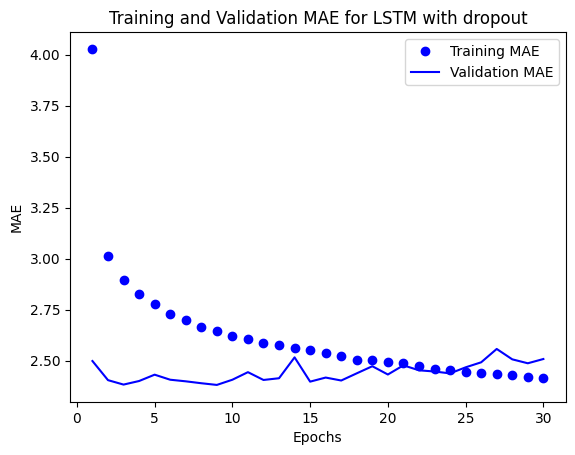

In [55]:
#Plotting results
import matplotlib.pyplot as plt
# assuming you have an object with a "history" which includes training records
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(mae) + 1)
plt.figure()
plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and Validation MAE for LSTM with dropout')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


Training and assessment of a GRU that is dropout-regulated

In [57]:
# Define the GRU model via dropout layers.
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
# Specify callbacks to preserve the optimal model.
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru_dropout.keras", save_best_only=True)
]
# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
# Train the model for 30 epochs
history = model.fit(train_dataset, epochs=30, validation_data=val_dataset, callbacks = callbacks)

Epoch 1/30
819/819 [==============================] - 82s 96ms/step - loss: 26.5970 - mae: 3.8393 - val_loss: 10.1978 - val_mae: 2.4828
Epoch 2/30
819/819 [==============================] - 80s 98ms/step - loss: 14.7497 - mae: 2.9841 - val_loss: 9.4261 - val_mae: 2.3895
Epoch 3/30
819/819 [==============================] - 83s 101ms/step - loss: 13.9350 - mae: 2.8958 - val_loss: 9.4585 - val_mae: 2.3989
Epoch 4/30
819/819 [==============================] - 83s 102ms/step - loss: 13.5386 - mae: 2.8524 - val_loss: 9.3269 - val_mae: 2.3821
Epoch 5/30
819/819 [==============================] - 81s 99ms/step - loss: 13.1060 - mae: 2.8077 - val_loss: 9.1148 - val_mae: 2.3508
Epoch 6/30
819/819 [==============================] - 78s 95ms/step - loss: 12.8318 - mae: 2.7776 - val_loss: 9.3972 - val_mae: 2.3938
Epoch 7/30
819/819 [==============================] - 76s 93ms/step - loss: 12.5862 - mae: 2.7525 - val_loss: 9.0138 - val_mae: 2.3375
Epoch 8/30
819/819 [==============================] 

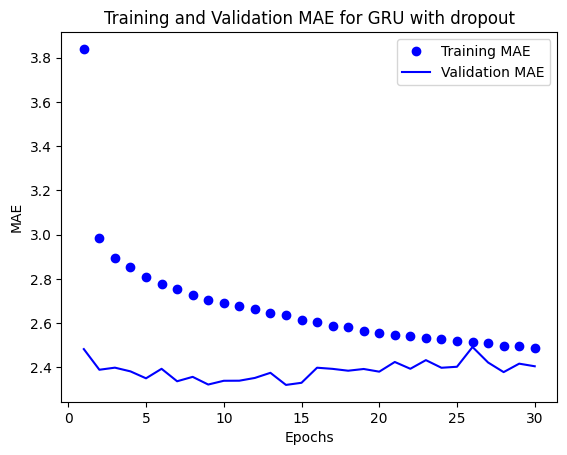

In [58]:
##Plotting results
import matplotlib.pyplot as plt
# Assuming you have 'history' object containing training history
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(mae) + 1)
plt.figure()
plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and Validation MAE for GRU with dropout')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


Training and evaluating a dropout-regularized, stacked GRU mode

In [66]:
# Define the stacked GRU model with dropout layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
# Define callbacks to save the best model
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras", save_best_only=True)
]
# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
# Train the model for 10 epochs
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)


Epoch 1/10
819/819 [==============================] - 155s 184ms/step - loss: 24.0497 - mae: 3.6396 - val_loss: 9.5916 - val_mae: 2.4087
Epoch 2/10
819/819 [==============================] - 152s 185ms/step - loss: 14.2031 - mae: 2.9192 - val_loss: 9.2346 - val_mae: 2.3631
Epoch 3/10
819/819 [==============================] - 144s 176ms/step - loss: 13.4594 - mae: 2.8453 - val_loss: 9.6774 - val_mae: 2.4295
Epoch 4/10
819/819 [==============================] - 147s 180ms/step - loss: 12.9519 - mae: 2.7863 - val_loss: 9.0303 - val_mae: 2.3314
Epoch 5/10
819/819 [==============================] - 143s 174ms/step - loss: 12.5243 - mae: 2.7418 - val_loss: 8.9758 - val_mae: 2.3284
Epoch 6/10
819/819 [==============================] - 151s 184ms/step - loss: 12.1365 - mae: 2.6988 - val_loss: 9.1420 - val_mae: 2.3535
Epoch 7/10
819/819 [==============================] - 145s 177ms/step - loss: 11.7625 - mae: 2.6557 - val_loss: 9.4369 - val_mae: 2.3822
Epoch 8/10
819/819 [=====================

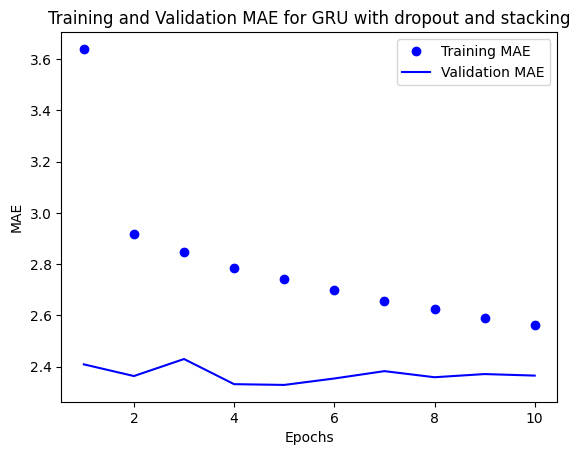

In [68]:
##PLotting result
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(mae) + 1)
plt.figure()
plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and Validation MAE for GRU with dropout and stacking')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()
